In [1]:
# compute number of assigned and unassignes transcripts

In [2]:
# using n_counts instead of manual boundary-transcript overlap

In [3]:
import sys

sys.path.insert(1, "/dss/dsshome1/0C/ra98gaq/Git/cellseg-benchmark")

In [4]:
# noqa: E402

import argparse
import logging
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc

# from cellseg_benchmark.cell_annotation_utils import flag_contamination, score_cell_types, annotate_cells_by_score
# warnings.filterwarnings("ignore")

In [5]:
# Logger setup
logger = logging.getLogger("metrics_assigned_transcripts")
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
handler.setFormatter(logging.Formatter("%(asctime)s [%(levelname)s]: %(message)s"))
logger.addHandler(handler)

In [6]:
parser = argparse.ArgumentParser(description="metrics_assigned_transcripts")
parser.add_argument("cohort", help="Cohort name, e.g., 'foxf2'")
# parser.add_argument("seg_method", help="Segmentation method, e.g., 'Cellpose_1_nuclei_model'")

# Simulate CLI args in Jupyter
args = parser.parse_args(["foxf2"])
print(args.cohort)

foxf2


In [7]:
# Paths
base_path = Path("/dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark")
analysis_path = base_path / "analysis" / args.cohort

results_path = base_path / "metrics" / args.cohort / "assigned_transcripts"
results_path.mkdir(parents=True, exist_ok=True)

plot_path = results_path / "plots"
plot_path.mkdir(parents=True, exist_ok=True)

from datetime import date  # noqa: E402

today = date.today().strftime("%Y%m%d")

In [8]:
# run once per cohort: load transcript.csv from master-sdata raw folder, from each sample, and save as csv in results_path
out_file = os.path.join(results_path, "transcript_counts_per_sample.csv")
if os.path.exists(out_file):
    print(f"File already exists, loading: {out_file}")
    df = pd.read_csv(out_file)
else:
    results = []
    for sample in os.listdir(os.path.join(base_path, "samples")):
        if not sample.startswith(args.cohort):
            continue
        print(f"Processing sample: {sample}")
        pfile = os.path.join(
            base_path,
            "samples",
            sample,
            "sdata_z3.zarr",
            "points",
            f"{sample}_transcripts",
            "points.parquet",
        )
        if not os.path.exists(pfile):
            warnings.warn(f"points.parquet missing for sample: {sample}")
            continue
        n_transcripts = len(pd.read_parquet(pfile))
        results.append({"sample": sample, "number_of_transcripts": n_transcripts})

    df = pd.DataFrame(results)
    df.to_csv(out_file, index=False)

Processing sample: foxf2_s7_r1


KeyboardInterrupt: 

In [40]:
df

,sample,number_of_transcripts
0,foxf2_s7_r1,85217008
1,foxf2_s1_r1,84195414
2,foxf2_s1_r0,89982343
3,foxf2_s4_r0,92975799
4,foxf2_s7_r0,88794851
5,foxf2_s6_r2,72436937
6,foxf2_s5_r0,58769454
7,foxf2_s3_r1,9582027
8,foxf2_s2_r2,71032194
9,foxf2_s3_r0,12103272


In [9]:
import pandas as pd

# Data
data = {
    "sample": [
        "foxf2_s7_r1",
        "foxf2_s1_r1",
        "foxf2_s1_r0",
        "foxf2_s4_r0",
        "foxf2_s7_r0",
        "foxf2_s6_r2",
        "foxf2_s5_r0",
        "foxf2_s3_r1",
        "foxf2_s2_r2",
        "foxf2_s3_r0",
        "foxf2_s2_r1",
        "foxf2_s4_r1",
        "foxf2_s6_r0",
        "foxf2_s6_r1",
        "foxf2_s5_r1",
    ],
    "number_of_transcripts": [
        85217008,
        84195414,
        89982343,
        92975799,
        88794851,
        72436937,
        58769454,
        9582027,
        71032194,
        12103272,
        66676355,
        80528580,
        65675519,
        73355523,
        34621932,
    ],
}

# Create DataFrame
df = pd.DataFrame(data)

# Save to CSV
# df.to_csv("sample_transcript_counts.csv", index=False)

In [10]:
df

,sample,number_of_transcripts
0,foxf2_s7_r1,85217008
1,foxf2_s1_r1,84195414
2,foxf2_s1_r0,89982343
3,foxf2_s4_r0,92975799
4,foxf2_s7_r0,88794851
5,foxf2_s6_r2,72436937
6,foxf2_s5_r0,58769454
7,foxf2_s3_r1,9582027
8,foxf2_s2_r2,71032194
9,foxf2_s3_r0,12103272


In [11]:
%%time
# loop through all available files in analysis (adata_integrated.h5ad), per seg_method, and extract transcript count per sample

all_summaries = []

for seg_method in os.listdir(analysis_path):
    adata_path = os.path.join(
        analysis_path, seg_method, "adatas", "adata_integrated.h5ad.gz"
    )
    if not os.path.exists(adata_path):
        print(f"[SKIP] No adata found for seg_method: {seg_method}")
        continue

    print(f"[INFO] Processing seg_method: {seg_method}")
    adata = sc.read_h5ad(adata_path)
    rows = []

    for sample in adata.obs["sample"].unique():
        print(f"    [SAMPLE] {sample}")
        total_count = int(
            df.loc[df["sample"] == sample, "number_of_transcripts"].values[0]
        )
        assigned_count = int(
            adata.obs.loc[adata.obs["sample"] == sample, "n_counts"].sum()
        )
        unassigned_count = total_count - assigned_count
        pct_assigned = assigned_count / total_count * 100 if total_count > 0 else 0
        rows.append(
            {
                "sample": sample,
                "assigned_count": assigned_count,
                "unassigned_count": unassigned_count,
                "total_count": total_count,
                "pct_assigned": pct_assigned,
            }
        )

    # Save sample-level stats
    sample_df = pd.DataFrame(rows)
    sample_outfile = os.path.join(
        results_path, f"{seg_method}_transcript_assignment_stats.csv"
    )
    sample_df.to_csv(sample_outfile, index=False)
    print(f"    [SAVED] Sample-level stats → {sample_outfile}")

    # Compute summary for seg_method
    total_assigned = sample_df["assigned_count"].sum()
    total_unassigned = sample_df["unassigned_count"].sum()
    total_transcripts = sample_df["total_count"].sum()
    pct_assigned_overall = (
        total_assigned / total_transcripts * 100 if total_transcripts > 0 else 0
    )
    all_summaries.append(
        {
            "seg_method": seg_method,
            "assigned_count": total_assigned,
            "unassigned_count": total_unassigned,
            "total_count": total_transcripts,
            "pct_assigned": pct_assigned_overall,
        }
    )

# Save summary across seg_methods
summary_outfile = os.path.join(results_path, "summary_per_seg_method.csv")
pd.DataFrame(all_summaries).to_csv(summary_outfile, index=False)
print(f"[DONE] Summary stats saved → {summary_outfile}")

[SKIP] No adata found for seg_method: Baysor_2D_Cellpose_2_DAPI_Transcripts_0.8
[INFO] Processing seg_method: vpt_2D_DAPI_nuclei
    [SAMPLE] foxf2_s7_r1
    [SAMPLE] foxf2_s1_r1
    [SAMPLE] foxf2_s1_r0
    [SAMPLE] foxf2_s4_r0
    [SAMPLE] foxf2_s7_r0
    [SAMPLE] foxf2_s6_r2
    [SAMPLE] foxf2_s5_r0
    [SAMPLE] foxf2_s2_r2
    [SAMPLE] foxf2_s2_r1
    [SAMPLE] foxf2_s4_r1
    [SAMPLE] foxf2_s6_r0
    [SAMPLE] foxf2_s6_r1
    [SAMPLE] foxf2_s5_r1
    [SAVED] Sample-level stats → /dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark/metrics/foxf2/assigned_transcripts/vpt_2D_DAPI_nuclei_transcript_assignment_stats.csv
[INFO] Processing seg_method: ComSeg
    [SAMPLE] foxf2_s2_r1
    [SAVED] Sample-level stats → /dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark/metrics/foxf2/assigned_transcripts/ComSeg_transcript_assignment_stats.csv
[INFO] Processing seg_method: Cellpose_1_nuclei_model
    [SAMPLE] foxf2_s7_r1
    [SAMPLE] foxf2_s1_r1
    [SAMPLE] foxf2_s1_r0
    [SAMPLE] foxf2_s4

In [12]:
import pandas as pd
import seaborn as sns

summary_outfile = os.path.join(results_path, "summary_per_seg_method.csv")
plot_data = pd.read_csv(summary_outfile)
plot_data = plot_data.sort_values("pct_assigned", ascending=False)

In [13]:
# exclude weird result temp
plot_data = plot_data[plot_data.seg_method != "vpt_3D_DAPI_PolyT_nuclei"]

In [24]:
plot_data = plot_data[plot_data.seg_method != "Negative_Control_Rastered_5"]
plot_data = plot_data[plot_data.seg_method != "Negative_Control_Rastered_10"]
plot_data = plot_data[plot_data.seg_method != "Negative_Control_Voronoi"]
plot_data = plot_data[
    plot_data.seg_method != "Baysor_2D_Cellpose_1_DAPI_Transcripts_0.2"
]
plot_data = plot_data[plot_data.seg_method != "Baysor_2D_Cellpose_1_DAPI_PolyT_0.2"]
plot_data = plot_data[plot_data.seg_method != "Baysor_2D_Cellpose_1_DAPI_PolyT_0.8"]


## issue! subsetting adata reduces this value!!

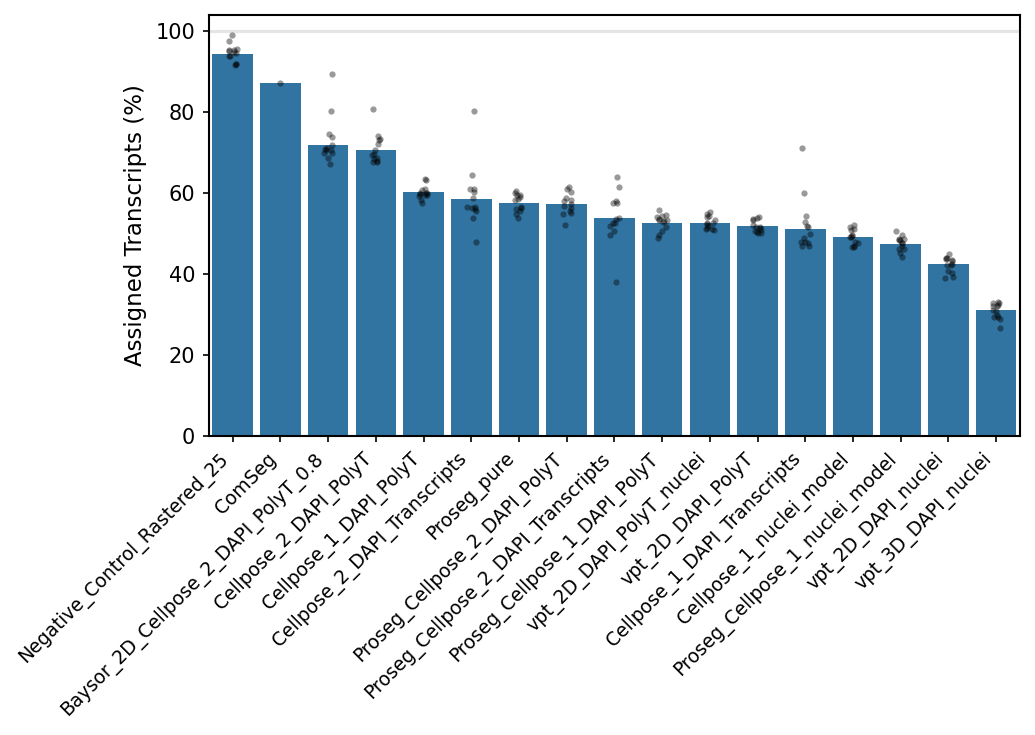

In [25]:
import os

import pandas as pd

# Load all individual sample-level CSVs
sample_data = []

for seg_method in plot_data["seg_method"]:  # ensures consistent order with barplot
    sample_file = os.path.join(
        results_path, f"{seg_method}_transcript_assignment_stats.csv"
    )
    if os.path.exists(sample_file):
        df_sample = pd.read_csv(sample_file)
        df_sample["seg_method"] = seg_method
        sample_data.append(df_sample)

sample_df = pd.concat(sample_data, ignore_index=True)

# Match ordering with barplot
sample_df["seg_method"] = pd.Categorical(
    sample_df["seg_method"], categories=plot_data["seg_method"], ordered=True
)

# Plot bar + scatter
plt.figure(figsize=(7, 5), dpi=150)
ax = sns.barplot(
    x="seg_method", y="pct_assigned", data=plot_data, edgecolor="none", width=0.85
)

sns.stripplot(
    x="seg_method",
    y="pct_assigned",
    data=sample_df,
    ax=ax,
    color="black",
    alpha=0.4,
    jitter=True,
    size=3,
)

ax.axhline(y=100, color="grey", linestyle="-", alpha=0.2)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=9)
ax.tick_params(
    axis="x",
    which="both",
    bottom=True,
    top=False,
    length=3,
    color="black",
    labelcolor="black",
)
ax.tick_params(
    axis="y",
    which="both",
    left=True,
    right=False,
    length=3,
    color="black",
    labelcolor="black",
)
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1)

plt.ylabel("Assigned Transcripts (%)", fontsize=11)
plt.xlabel("")
plt.tight_layout()
plt.show()

/home/ubuntu/miniforge3/envs/cellseg_benchmark/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 15.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/miniforge3/envs/cellseg_benchmark/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/miniforge3/envs/cellseg_benchmark/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 30.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/miniforge3/envs/cellseg_benchmark/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 23.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warni

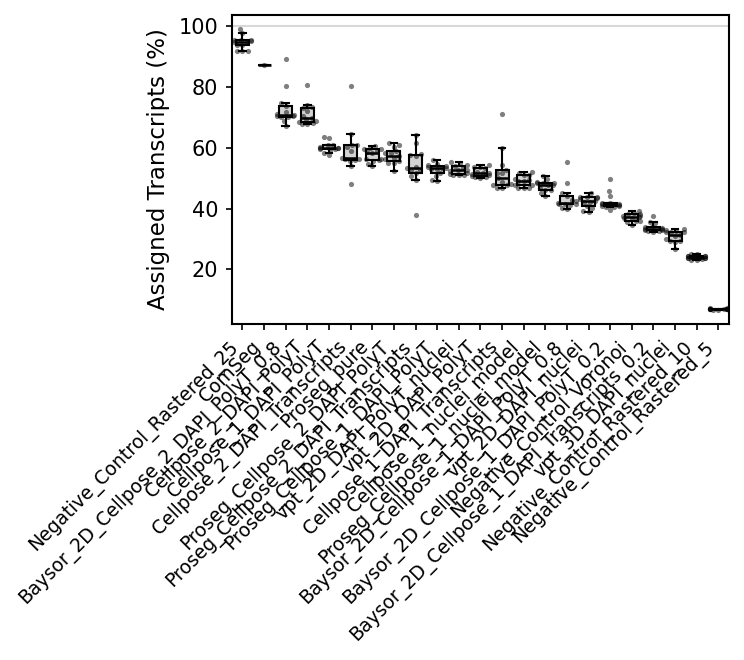

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 4.5), dpi=150)

ax = sns.boxplot(
    x="seg_method",
    y="pct_assigned",
    data=sample_df,
    showfliers=False,
    width=0.6,
    boxprops=dict(edgecolor="black", facecolor="lightgray", linewidth=1),
    medianprops=dict(color="black", linewidth=1.2),
    whiskerprops=dict(color="black", linewidth=1),
    capprops=dict(color="black", linewidth=1),
)

sns.swarmplot(
    x="seg_method",
    y="pct_assigned",
    data=sample_df,
    ax=ax,
    color="black",
    size=2.5,
    alpha=0.5,
)

ax.axhline(y=100, color="grey", linestyle="-", alpha=0.3, linewidth=1)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=9)
ax.tick_params(
    axis="x", bottom=True, top=False, length=3, color="black", labelcolor="black"
)
ax.tick_params(
    axis="y", left=True, right=False, length=3, color="black", labelcolor="black"
)

for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1)

plt.ylabel("Assigned Transcripts (%)", fontsize=11)
plt.xlabel("")
plt.tight_layout()
plt.show()